In [1]:
import acquire
import prepare
import explore
import model
import pandas as pd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# modeling
from sklearn.linear_model import LinearRegression
from math import sqrt
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# Project Overview

We will conduct an in depth analysis of Zillow property data from 2017. We will use exploratory analysis techniques to identify the key drivers of the assessed tax value for those properties, then use machine learning algorithms to create a model capable of predicting tax values based on features of the property. 

# Project Description

Property values have skyrocketed over the last two years. With such rapid changes in home values, predicting those values has become even more challenging than before. Since Zillow's estimate of home value is one of the primary drivers of its website traffic, having a reliable estimate is paramount. Any improvement we can make on the previous model will help us out-estimate our competitors and keep us at the top as the most trusted name in real estate technology. 

This project will analyze property attributes in relation to their 2017 assessed tax value, develop a model for predicting that value based on those attributes, and leave with recommendations for how to improve future predictions. 

# Project Goals

By improving upon the previous model, Zillow can enhance it's reputation for reliable property value estimates and better position itself in the real estate technology marketplace. 


# Acquisition

In this stage, we use a SQL query to access the Codeup MySQL database and join together all the relevant data using the following tables:

- properties_2017
- propertylandusetype
- predictions_2017

The data obtained includes all properties in the dataset which had a transaction in 2017.

In [2]:
df = acquire.zillow_2017_data()

Reading from local CSV...


# Preparation

In this stage, we clean and prepare the data for further exploration and modeling and encapsulate the relevant code in the prepare modele. 

The `prep_zillow_1` function accomplishes the following:

- checks for null values and removes all rows with null values if the number of null values is less than 5% the number of observations in the dataset. 
    - less than 5% of values is judged to not have a significant effect on a large dataset. Greater than 5% of values might require additional consideration. 
    - in this case we removed about 0.2% of the total observations due to null values
- renames columns for readability
- changes data types where appropriate (such as numerical codes into string values)
- adds a feature 'age', which represents years since the home was constructed

In [3]:
df = prepare.prep_zillow_1(df)

**Split the data** into train, test, and validate samples

In [4]:
train, test, validate = prepare.train_test_validate_split(df)

train	 n = 29298
test	 n = 10464
validate n = 12557


**Removing Outliers**

During initial exploration, it was discovered that extreme outliers exist in the categories of tax_value, bedrooms, bathrooms, sqft, and age. 

We judge that out model will generalize more effectively if it is focused on the typical (i.e. median) homes. Further, we expect that markets for luxury and historical homes (likely represented by these outliers) are considerably different than the general home market, and that an altogether separate model would be more useful for predicting the values of such homes. 

We will therefore drop outliers from this dataset. 

The `remove` outliers function calculates a range defining outliers based on the training sample, then removes values outside this range in all samples.

In [5]:
# remove outliers based on a range calculated from the training sample
train, validate, test = prepare.remove_outliers(train, validate, test, 1.5, ['bedrooms', 'bathrooms',                                                                        'sqft', 'age', 'tax_value'])

# Exploration

### Which features have the highest correlations with tax_value?

The `value_correlations()` function from the `explore` module displays a heatmap of correlations between each feature and out target variable. 

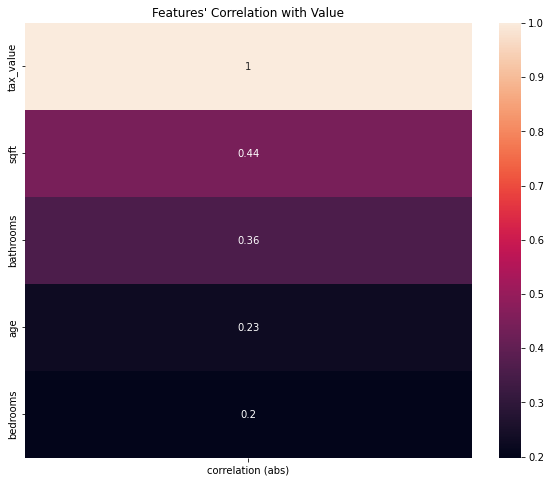

In [6]:
explore.value_correlations(train)

We can see that of our features, sqft and bathrooms have the highest correlation with the tax value of the home. The .44 and .36 r values are considerably higher than the correlation with bedrooms at r = .20. 

Are these correlation values statistically significant?

### Further exploration: Is there a significant correlation between number of bathrooms and value?

The `value_by_bathrooms` function from the `explore` module displays boxplots for each number of bathrooms in our sample. We can see that as the nuber of bathrooms increases, the average value tends to be higher, and the overall distribution of values tends to be higher as well. 

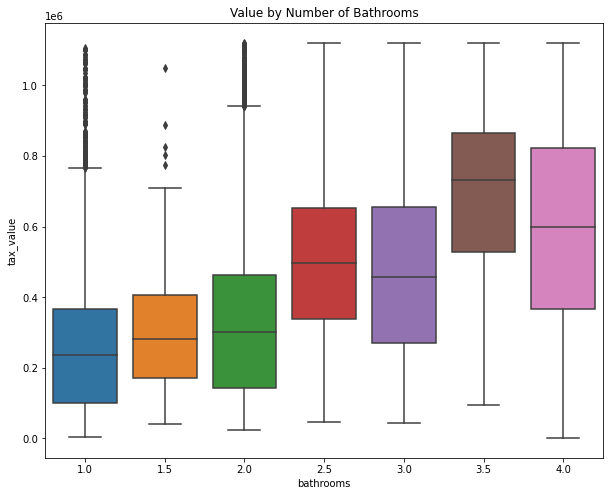

In [7]:
explore.value_by_bathrooms(train)

The `correlation_test` function from the `explore` module performs a Pearson's r statistical test for correlation:

In [8]:
explore.correlation_test(train.bathrooms, train.tax_value)

H0: There is no linear correlation between bathrooms and tax_value.
H1: There is a linear correlation between bathrooms and tax_value.

r =  0.36
p =  0.0

Reject H0


With a p-value of virtually 0, we reject the null hypothesis and proceed under the assumption that there is a linear relationship between number of bathrooms and tax_value. since this relationship is unlikely to be due to chance. 

### Further exploration: Is there a significant correlation between the number of bedrooms in a home and it's value?

The `value_by_bedrooms` function from the `explore` module displays boxplots for each number of bedrooms in our sample. We can see that as the nuber of bedrooms increases, the average value tends to be higher, and the overall distribution of values tends to be higher as well. 

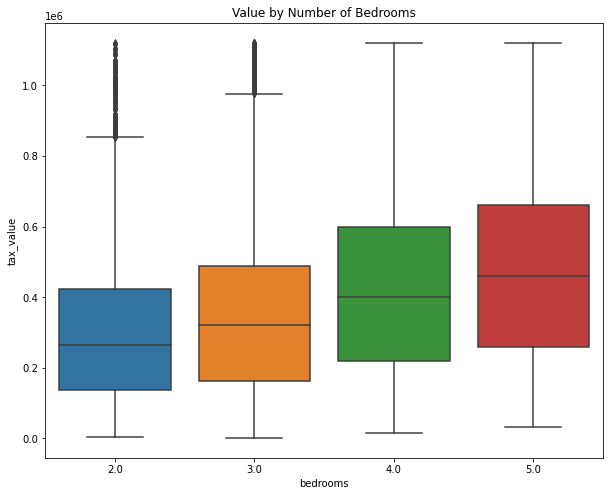

In [9]:
   explore.value_by_bedrooms(train)

The `correlation_test` function from the `explore` module performs a Pearson's r statistical test for correlation:

In [10]:
explore.correlation_test(train.bedrooms, train.tax_value)

H0: There is no linear correlation between bedrooms and tax_value.
H1: There is a linear correlation between bedrooms and tax_value.

r =  0.2
p =  0.0

Reject H0


With a p-value of virtually 0, we reject the null hypothesis and proceed under the assumption that there is a linear relationship between the number of bedrooms in a home and tax_value, since this relationship in our sample is unlikely to be due to chance. 

### Further exploration: Is there a significant correlation between a home's square footage and it's value?

The `sqft_vs_value` function from the `explore` module displays a scatter plot of the relationship between these two variables. 

(a random sample of n=1000 data is used to make the plot less dense))

We can see that, while there does tend to be a wide disbursement of values at all points of the distribution, There is an overall trend of an increase in value as the square footage increases. 

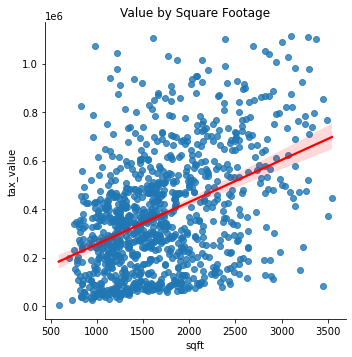

In [11]:
explore.sqft_vs_value(train)

The `correlation_test` function from the `explore` module performs a Pearson's r statistical test for correlation:

In [12]:
explore.correlation_test(train.sqft, train.tax_value)

H0: There is no linear correlation between sqft and tax_value.
H1: There is a linear correlation between sqft and tax_value.

r =  0.44
p =  0.0

Reject H0


With a p-value of virtually 0, we reject the null hypothesis and proceed under the assumption that there is a linear relationship between the square footage of the home and tax_value, since this relationship in our sample is unlikely to be due to chance. 

## Exploration: Summary

In exploring the relationship between each of the features and our target, we found significant linear correlation between tax value and square footage, bedrooms, and bathrooms. We will use these features in our model moving forward. For simplicity in creating our initial models, we will omit all other variables for the time being. 

Since age of the property also appears to be correlated with value, this is a feature that we may include in subsequent iterations of modeling. 

# Modeling

In [13]:
# identify the name of the target feature
target = 'tax_value'

#### Splitting the data:

First, we split our data into three samples, train, test, and validate. Our models will learn information about the data from the train sample, we will then measure model performance on the validate sample. Once we have chosen the best performing model, we will use it on the test sample to approximate how our model will perform on future unseen data.

The `train_test_validate` function from the `prepare` module performs the splitting actions.

In [14]:
train, test, validate = prepare.train_test_validate_split(df)

train	 n = 29298
test	 n = 10464
validate n = 12557


#### Scaling the data

Next, we will scale the values of each of our quantitative features so that they will be appropriately compared to each other within our models. In this case, we have used a Min-Max scaler, which will convert all values to within a range of 0 to 1. 

The `scale_zillow` function from the `prepare` module performs these scaling actions. 

In [15]:
train, validate, test = prepare.scale_zillow(train, validate, test, target)

#### Encoding the data

We will also encode each of our categorical features into a numerical data type that is interpretable by ML algorithms. 

The `encode_zillow` function from the prepare module performs these encoding actions. 

In [16]:
train, validate, test = prepare.encode_zillow(train, validate, test, target)

#### Establishing Baseline Performance

The code below sets up the necessary infrastructure for storing information about each of our models and their performance

In [17]:
model_number = 0 
model_info = pd.DataFrame()
model_results = pd.DataFrame()

Next we will establish our baseline predictions and evaluate their performance. 

To be able to determine whether our model gives useful predictions, we will compare it to a model that uses no features at all, and simply uses the mean value as a prediction for all observations. 

The `run_baseline` function from the `model` stores information about baseline predictions and their performance for later evaluation. 

In [18]:
model_number, model_info, model_results = model.run_baseline(train, validate, target, model_number, model_info, model_results)

#### Modeling: Ordinary Least Squares (OLS) Regression

In [19]:
model_number, model_info, model_results = model.run_OLS(train, validate, target, model_number, model_info, model_results)

## Model Evaluation

**Root Mean Squared Error (RMSE):** This is the metric we will use to evaluate the performance of our models. The RMSE tells us the standard deviation of the difference between our predictions and the actual values and therefore gives us an idea of how spread out the actual data points are around our regression line. Of the possible metrics for evaluating regression models, RMSE is easiest to interpret since it is expressed in units that are equivalent to our target variable (dollars in this case). 

Below, the model_info dataframe provides information about each model that we tested and the features that were included, and the model_results dataframe displays the RMSE for that model on each of the train and validate samples. 

In [21]:
model_info

,model_number,model_type,features
0,baseline,baseline,NaN
1,1,OLS linear regression,"[scaled_bedrooms, scaled_bathrooms, scaled_sqft]"
2,2,OLS linear regression,"[scaled_bedrooms, scaled_bathrooms, scaled_sqf..."
3,3,OLS linear regression,"[scaled_bedrooms, scaled_bathrooms, scaled_sqf..."


In [22]:
model_results

,model_number,sample_type,metric_type,score
0,baseline,train,RMSE,770523.326432
1,baseline,validate,RMSE,724203.010418
2,1,train,RMSE,607991.301090
3,1,validate,RMSE,558063.125024
4,2,train,RMSE,600407.685352
5,2,validate,RMSE,551655.154095
6,3,train,RMSE,600180.874460
7,3,validate,RMSE,551357.742032


Model 1, which includes number of bedrooms, number of bathrooms, and square footage as features, is our highest performing model. It has an RMSE of 60,7991 on the train sample and 558,063 on the validate sample. 

#### Modeling - Final Test

Now we will evaluate this model's performance on our test sample. This will approximate the expected performance of this model for predicting prices of additional properties in real-time.

The `final_test_model1` function peforms this test and displays the results.

In [46]:
model.final_test_model1(train, test)

Model 1 RMSE:  $553,751.66
